<a href="https://colab.research.google.com/github/Serurays/Brain_Tumor_Prediction_Binary.ipynb/blob/main/Brain_Tumor_Prediction_Binary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d navoneel/brain-mri-images-for-brain-tumor-detection
!unzip brain-mri-images-for-brain-tumor-detection.zip

mkdir: cannot create directory ‘/root/.kaggle’: File exists
User cancelled operation
Archive:  brain-mri-images-for-brain-tumor-detection.zip
replace brain_tumor_dataset/no/1 no.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2

In [ ]:
TRAIN_DIR = "/content/Training/"

In [ ]:
from tensorflow.keras.applications.resnet50 import preprocess_input

train_data_gen = ImageDataGenerator(validation_split=0.2, preprocessing_function=preprocess_input)

train_generator = train_data_gen.flow_from_directory(TRAIN_DIR,
                                                     target_size=(224, 224),
                                                     color_mode='rgb',
                                                     batch_size=32,
                                                     shuffle=True,
                                                     subset='training')

validation_generator = train_data_gen.flow_from_directory(TRAIN_DIR,
                                                          target_size=(224, 224),
                                                          color_mode='rgb',
                                                          batch_size=32,
                                                          shuffle=False,
                                                          subset='validation')

Found 203 images belonging to 2 classes.
Found 50 images belonging to 2 classes.


In [ ]:
labels = train_generator.class_indices
class_mapping = dict((v, k) for k, v in labels.items())

In [ ]:
class_mapping

{0: 'no', 1: 'yes'}

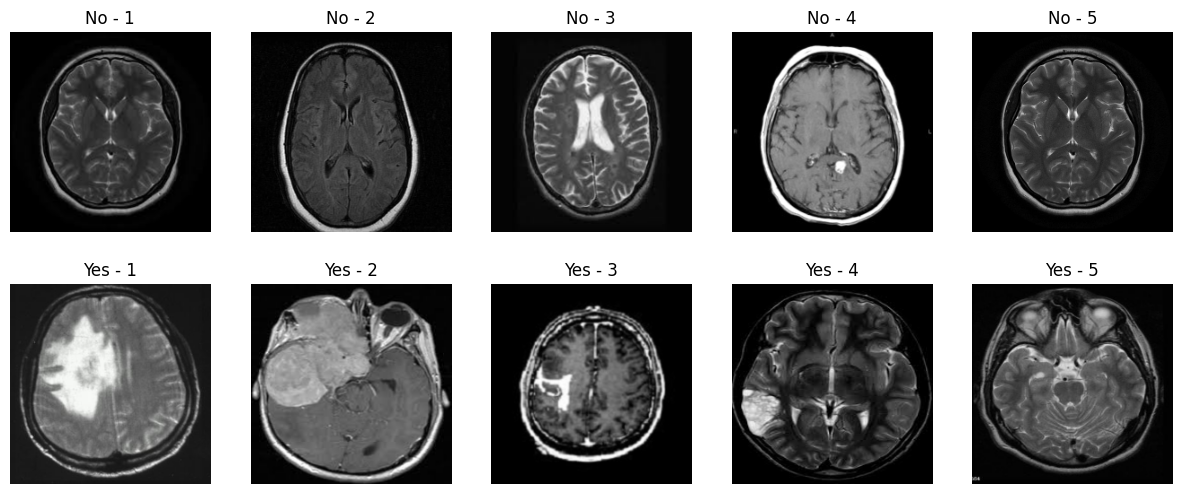

In [ ]:
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def plot_random_images(dataset_path, class_labels=('no', 'yes'), num_images=5):
    plt.figure(figsize=(15, 6))

    for class_label in class_labels:
        class_path = os.path.join(dataset_path, class_label)
        image_files = os.listdir(class_path)
        random_images = random.sample(image_files, num_images)

        for i, image_file in enumerate(random_images, start=1):
            plt.subplot(len(class_labels), num_images, (class_labels.index(class_label) * num_images) + i)

            img_path = os.path.join(class_path, image_file)
            img = mpimg.imread(img_path)
            img = cv2.resize(img, (224, 224))
            plt.imshow(img, cmap='gray')

            plt.axis('off')
            plt.title(f'{class_label.capitalize()} - {i}')

    plt.show()

dataset_path = '/content/Training'
plot_random_images(dataset_path)


In [ ]:
from keras.applications import vgg16

img_rows, img_cols = 224, 224

vgg = vgg16.VGG16(weights="imagenet",
                  include_top=False,
                  input_shape=(img_rows, img_cols, 3))

for layer in vgg.layers:
  layer.trainable = False

for (i, layer) in enumerate(vgg.layers):
  print(str(i) + " " + layer.__class__.__name__, layer.trainable)

0 InputLayer False
1 Conv2D False
2 Conv2D False
3 MaxPooling2D False
4 Conv2D False
5 Conv2D False
6 MaxPooling2D False
7 Conv2D False
8 Conv2D False
9 Conv2D False
10 MaxPooling2D False
11 Conv2D False
12 Conv2D False
13 Conv2D False
14 MaxPooling2D False
15 Conv2D False
16 Conv2D False
17 Conv2D False
18 MaxPooling2D False


In [ ]:
def structure_model(bottom_model, num_classes):
    top_model = bottom_model.output
    top_model = GlobalAveragePooling2D()(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dense(512,activation='relu')(top_model)
    top_model = Dense(num_classes,activation='sigmoid')(top_model)
    return top_model

In [ ]:
from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.models import Model

num_classes = 2

model_head = structure_model(vgg, num_classes)

model = Model(inputs = vgg.input, outputs = model_head)

print(model.summary())

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [ ]:
from tensorflow.keras.optimizers import Adam

opt = Adam(learning_rate=0.0001)

model.compile(loss='binary_crossentropy',optimizer=opt,metrics=['accuracy'])

In [ ]:
from keras.callbacks import ModelCheckpoint

train_cb = ModelCheckpoint('model/', save_best_only=True)

history = model.fit(train_generator, validation_data=validation_generator, callbacks=[train_cb], epochs=5)

Epoch 1/5
7/7 [==============================] - 5s 540ms/step - loss: 0.1457 - accuracy: 0.9606 - val_loss: 0.2685 - val_accuracy: 0.9200
Epoch 2/5
7/7 [==============================] - 4s 552ms/step - loss: 0.0832 - accuracy: 0.9852 - val_loss: 0.2634 - val_accuracy: 0.9000
Epoch 3/5
7/7 [==============================] - 1s 175ms/step - loss: 0.0542 - accuracy: 0.9951 - val_loss: 0.2921 - val_accuracy: 0.9200
Epoch 4/5
7/7 [==============================] - 3s 508ms/step - loss: 0.0364 - accuracy: 0.9951 - val_loss: 0.2609 - val_accuracy: 0.9200
Epoch 5/5
7/7 [==============================] - 1s 180ms/step - loss: 0.0284 - accuracy: 1.0000 - val_loss: 0.2715 - val_accuracy: 0.9400


2/2 [==============================] - 0s 109ms/step
              precision    recall  f1-score   support

           0       0.94      0.89      0.92        19
           1       0.94      0.97      0.95        31

    accuracy                           0.94        50
   macro avg       0.94      0.93      0.94        50
weighted avg       0.94      0.94      0.94        50



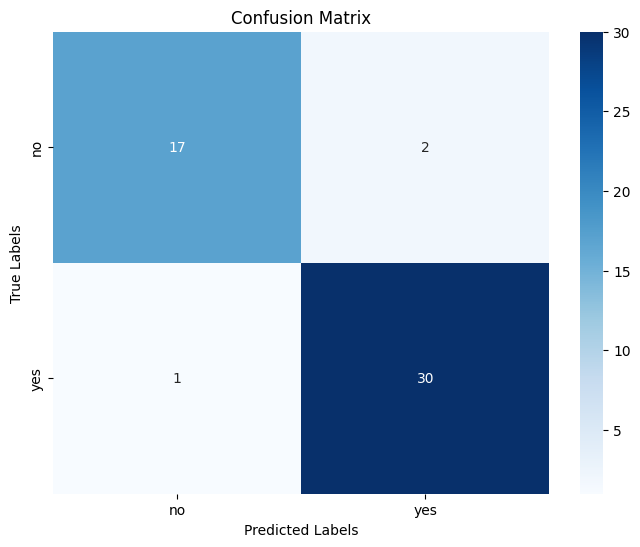

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

predictions = model.predict(validation_generator)

true_labels = validation_generator.classes

predicted_labels = np.argmax(predictions, axis=1)

conf_matrix = confusion_matrix(true_labels, predicted_labels)
cr = classification_report(true_labels, predicted_labels)
print(cr)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_mapping.values(), yticklabels=class_mapping.values())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

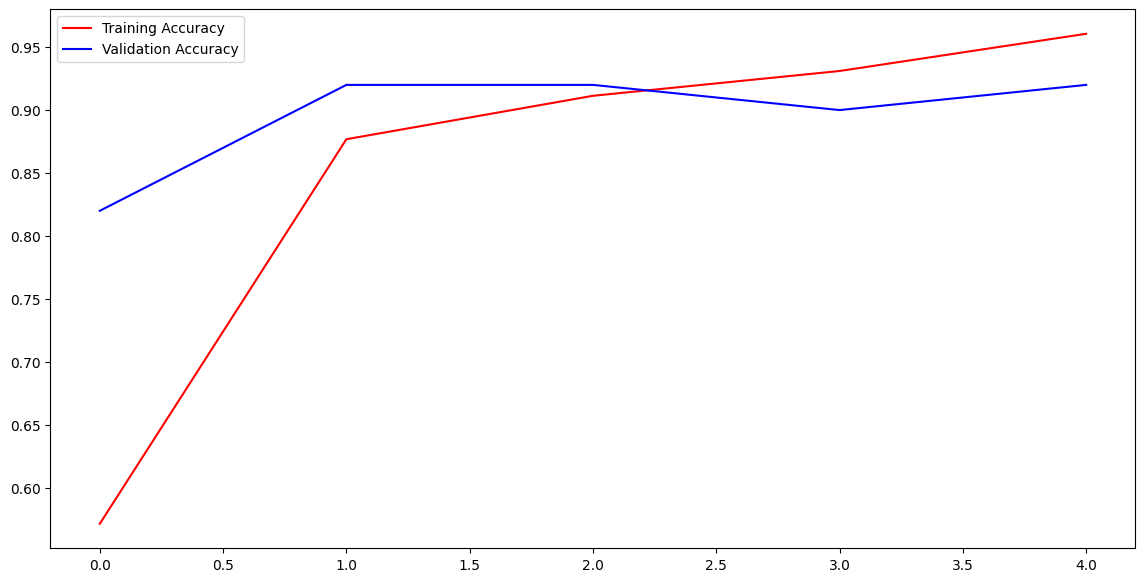

In [ ]:
import seaborn as sns

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))
fig = plt.figure(figsize=(14,7))
plt.plot(epochs,acc,'r',label="Training Accuracy")
plt.plot(epochs,val_acc,'b',label="Validation Accuracy")
plt.legend(loc='upper left')
plt.show()

In [ ]:
img = cv2.imread('/content/Training/yes/Y10.jpg')
img = cv2.resize(img,(224,224))
img_array = np.array(img)
img_array.shape

(224, 224, 3)

In [ ]:
img_array = img_array.reshape(1,224,224,3)
img_array.shape

(1, 224, 224, 3)

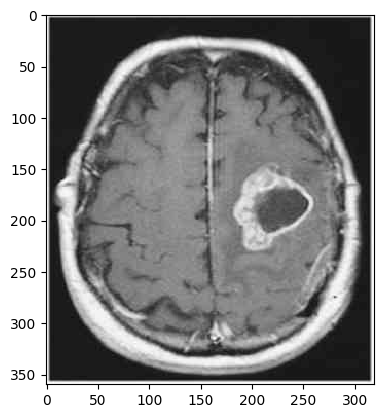

In [ ]:
from tensorflow.keras.preprocessing import image
img = image.load_img('/content/Training/yes/Y10.jpg')
plt.imshow(img,interpolation='nearest')
plt.show()

In [ ]:
a=model.predict(img_array)
indices = a.argmax()
indices

1/1 [==============================] - 0s 170ms/step


1